In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
data = np.load("/content/drive/My Drive/no_ufos.npz")


X_train = data['X_train']
y_train = data['y_train']


print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
# print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)


Original dataset size: 2505
Number of augmentations required: 22495
Dataset size after augmentation: 27505
Dataset size after cleaning: 27505
Visualizing some results after cleaning...


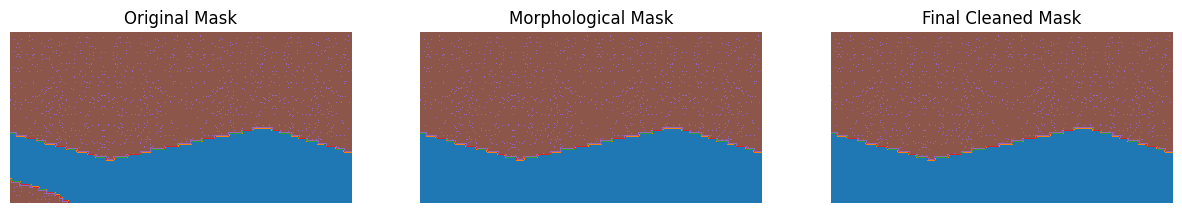

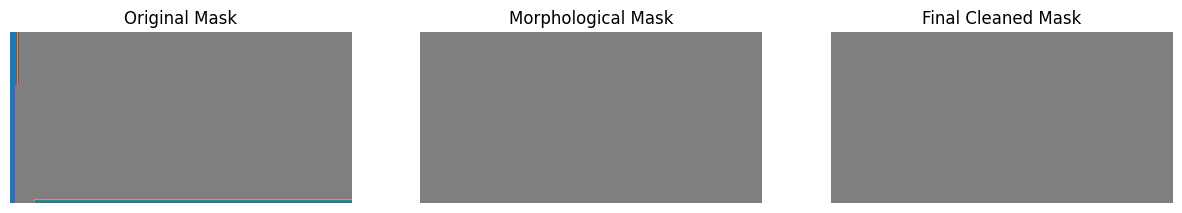

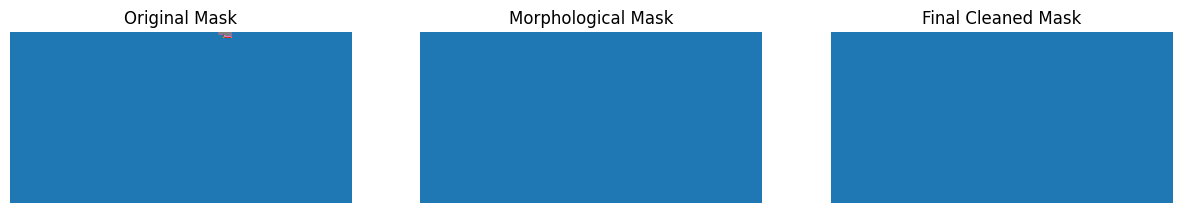

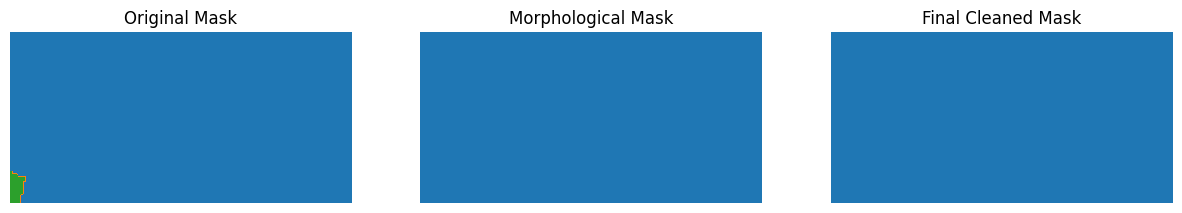

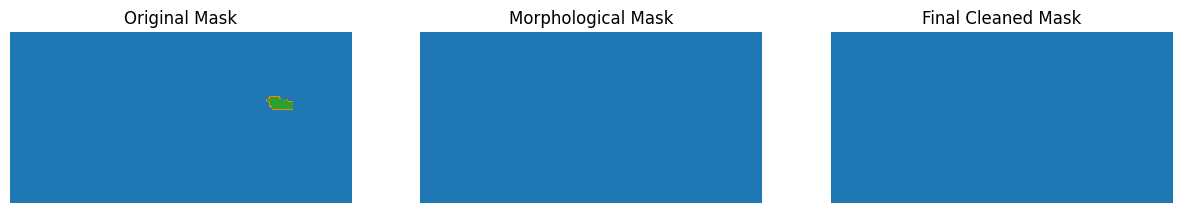

Final dataset size: 27505, 27505


In [ ]:
#In this part the code was ran on making 5000 samples but we previously ran on making 25000 as we talked about it in the report
!pip install -U albumentations
import numpy as np
import cv2
from albumentations import Compose, RandomRotate90, HorizontalFlip, Transpose, CLAHE, RandomBrightnessContrast, GaussNoise
from albumentations import ElasticTransform, GridDistortion, OpticalDistortion, OneOf
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy.stats import zscore
import matplotlib.pyplot as plt
from collections import Counter

# Albumentations Pipeline
def get_augmentation_pipeline():
    return Compose([
        RandomRotate90(),
        HorizontalFlip(p=0.5),
        Transpose(),
        OneOf([
            CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),  # Ensure input is uint8 grayscale
            RandomBrightnessContrast(),
            GaussNoise()
        ], p=0.3),
        OneOf([
            ElasticTransform(alpha=1, sigma=50),
            GridDistortion(),
            OpticalDistortion(distort_limit=1.0, shift_limit=0.5)
        ], p=0.3)
    ])




def augment_image(image, mask, pipeline, target_shape=(64, 128)):
    """
    Apply Albumentations augmentations to an image and mask, then resize to target shape.
    Args:
        image: Input image.
        mask: Corresponding mask.
        pipeline: Albumentations augmentation pipeline.
        target_shape: Desired output shape (H, W).

    Returns:
        Augmented and resized image and mask.
    """
    # Ensure the image is grayscale and uint8
    if len(image.shape) == 3:  # Convert to grayscale if needed
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if image.dtype != np.uint8:  # Ensure uint8 format
        image = (image * 255).astype(np.uint8)

    augmented = pipeline(image=image, mask=mask)
    augmented_image = cv2.resize(augmented['image'], target_shape[::-1], interpolation=cv2.INTER_LINEAR)
    augmented_mask = cv2.resize(augmented['mask'], target_shape[::-1], interpolation=cv2.INTER_NEAREST)
    return augmented_image, augmented_mask


# Synthetic Data Generation (Cut-and-Paste)
def cut_and_paste(images, masks, target_class=4, num_augmentations=100):
    augmented_images, augmented_masks = [], []
    for _ in range(num_augmentations):
        idx = np.random.choice([i for i, mask in enumerate(masks) if np.any(mask == target_class)])
        img, mask = images[idx], masks[idx]
        coords = np.argwhere(mask == target_class)
        top_left = coords.min(axis=0)
        bottom_right = coords.max(axis=0)
        patch = img[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        patch_mask = mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        dest_idx = np.random.randint(len(images))
        dest_img, dest_mask = images[dest_idx].copy(), masks[dest_idx].copy()
        h, w = patch.shape[:2]
        y, x = np.random.randint(0, dest_img.shape[0] - h), np.random.randint(0, dest_img.shape[1] - w)
        dest_img[y:y + h, x:x + w] = patch
        dest_mask[y:y + h, x:x + w] = patch_mask
        augmented_images.append(dest_img)
        augmented_masks.append(dest_mask)
    return np.array(augmented_images), np.array(augmented_masks)

def oversample_class(X, y, target_class=4, num_samples=1000):
    class_indices = [i for i, mask in enumerate(y) if np.any(mask == target_class)]
    X_class = X[class_indices]
    y_class = y[class_indices]
    oversampled_X, oversampled_y = [], []
    pipeline = get_augmentation_pipeline()
    for _ in range(num_samples):
        idx = np.random.randint(len(X_class))
        img, mask = X_class[idx], y_class[idx]
        aug_img, aug_mask = augment_image(img, mask, pipeline)

        # Resize augmented images and masks to the original shape
        aug_img = cv2.resize(aug_img, (X_class[0].shape[1], X_class[0].shape[0]))
        aug_mask = cv2.resize(aug_mask, (y_class[0].shape[1], y_class[0].shape[0]), interpolation=cv2.INTER_NEAREST)

        oversampled_X.append(aug_img)
        oversampled_y.append(aug_mask)
    return np.array(oversampled_X), np.array(oversampled_y)


# Morphological Cleaning
def clean_mask(mask, min_size=300):
    cleaned_mask = np.zeros_like(mask)
    for class_label in range(1, 5):
        class_region = mask == class_label
        cleaned_region = remove_small_objects(class_region, min_size=min_size)
        cleaned_region = remove_small_holes(cleaned_region, area_threshold=min_size)
        cleaned_mask[cleaned_region] = class_label
    return cleaned_mask

# Statistical Cleaning
def compute_class_proportions(masks, num_classes=5):
    proportions = []
    for mask in masks:
        mask = mask.astype(int)
        pixel_counts = np.bincount(mask.flatten(), minlength=num_classes)
        proportions.append(pixel_counts / mask.size)
    return np.array(proportions)

def detect_mislabeled_masks(class_proportions, z_threshold=2.5):
    z_scores = zscore(class_proportions, axis=0, ddof=1)
    mislabeled_indices = np.where(np.abs(z_scores) > z_threshold)[0]
    return mislabeled_indices

def replace_outlier_regions(mask, flagged_classes):
    cleaned_mask = mask.copy()
    for cls in flagged_classes:
        cleaned_mask[mask == cls] = 0
    return cleaned_mask

# Augment Dataset with Cleaning
def augment_dataset_with_cleaning(X, y, target_size=5000, target_class=4, min_size=300, z_threshold=2.5):
    """
    Augment and clean the dataset to achieve a target size.
    Args:
        X: Original images (numpy array).
        y: Original masks (numpy array).
        target_size: Desired total size of the dataset.
        target_class: Class to focus on for specific augmentations.
        min_size: Minimum size for morphological cleaning.
        z_threshold: Z-score threshold for statistical cleaning.

    Returns:
        Augmented and cleaned dataset (X_augmented, y_cleaned).
    """
    current_size = len(X)
    num_augmentations = target_size - current_size
    if num_augmentations <= 0:
        print("Dataset already meets or exceeds target size.")
        return X, y

    print(f"Original dataset size: {current_size}")
    print(f"Number of augmentations required: {num_augmentations}")

    # Albumentations Pipeline
    pipeline = get_augmentation_pipeline()
    X_aug, y_aug = [], []
    for img, mask in zip(X, y):
        aug_img, aug_mask = augment_image(img, mask, pipeline, target_shape=(64, 128))
        X_aug.append(aug_img)
        y_aug.append(aug_mask)
    X_aug = np.array(X_aug)  # Convert to numpy array
    y_aug = np.array(y_aug)

    # Synthetic Data Generation
    num_synthetic = num_augmentations // 2
    X_synthetic, y_synthetic = cut_and_paste(X, y, target_class=target_class, num_augmentations=num_synthetic)

    # Oversampling
    num_oversampled = num_augmentations - num_synthetic
    X_oversampled, y_oversampled = oversample_class(X, y, target_class=target_class, num_samples=num_oversampled)

    # Combine Datasets
    X_augmented = np.concatenate([X, X_aug, X_synthetic, X_oversampled], axis=0)
    y_augmented = np.concatenate([y, y_aug, y_synthetic, y_oversampled], axis=0)

    print(f"Dataset size after augmentation: {len(X_augmented)}")

    # Morphological Cleaning
    y_morph_cleaned = np.array([clean_mask(mask, min_size=min_size) for mask in y_augmented])

    # Statistical Cleaning
    class_proportions = compute_class_proportions(y_morph_cleaned, num_classes=5)
    mislabeled_indices = detect_mislabeled_masks(class_proportions, z_threshold=z_threshold)
    for idx in mislabeled_indices:
        y_morph_cleaned[idx] = replace_outlier_regions(y_morph_cleaned[idx], flagged_classes=[1, 4])

    print(f"Dataset size after cleaning: {len(X_augmented)}")
    return X_augmented, y_morph_cleaned


# Visualization
def visualize_cleaning(original_mask, morph_mask, final_mask):


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_mask, cmap="tab10", vmin=0, vmax=4)
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(morph_mask, cmap="tab10", vmin=0, vmax=4)
    plt.title("Morphological Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(final_mask, cmap="tab10", vmin=0, vmax=4)
    plt.title("Final Cleaned Mask")
    plt.axis("off")
    plt.show()

# Main Workflow
def main_workflow_with_target_size(X_train, y_train, target_size=25000, target_class=4, min_size=300, z_threshold=2.5):
    X_augmented, y_cleaned = augment_dataset_with_cleaning(
        X_train, y_train, target_size=target_size, target_class=target_class, min_size=min_size, z_threshold=z_threshold
    )
    print("Visualizing some results after cleaning...")
    for i in range(5):  # Visualize the first 5 masks
        visualize_cleaning(y_train[i], y_cleaned[i], y_cleaned[i])
    print(f"Final dataset size: {len(X_augmented)}, {len(y_cleaned)}")
    return X_augmented, y_cleaned

# Example Usage
X_augmented, y_cleaned = main_workflow_with_target_size(
    X_train, y_train, target_size=5000, target_class=4, min_size=300, z_threshold=2.5
)


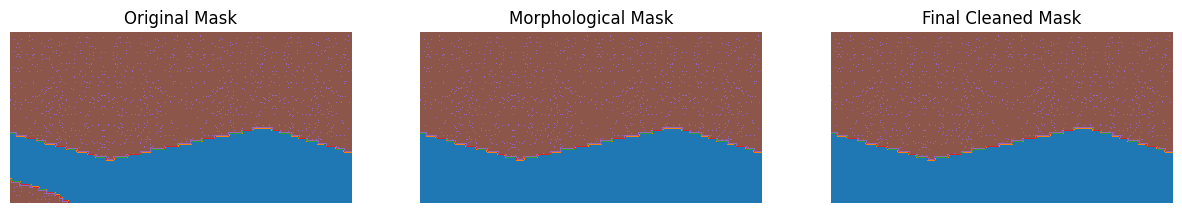

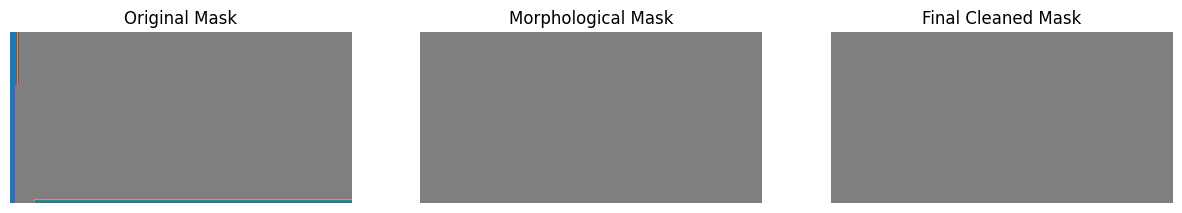

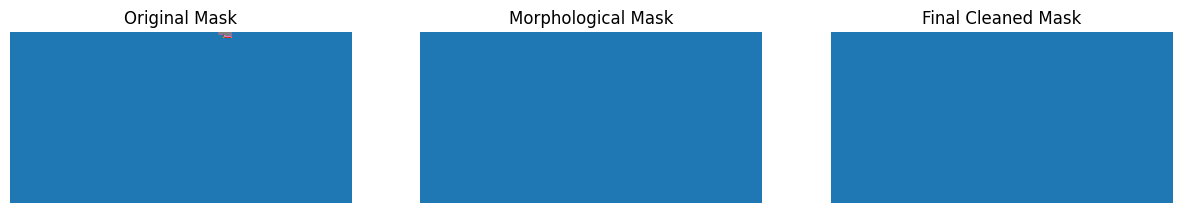

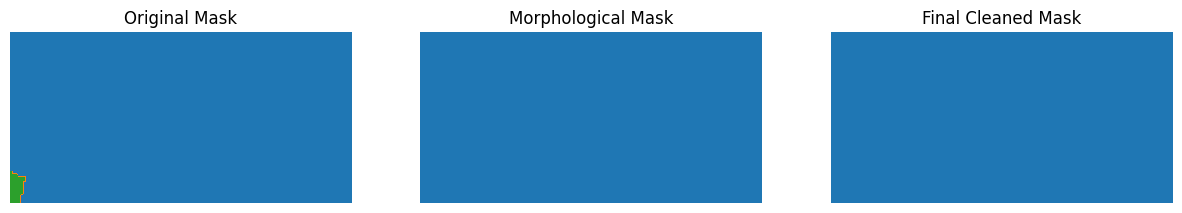

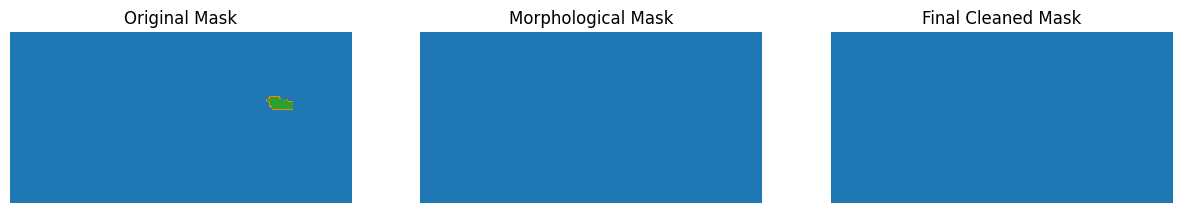

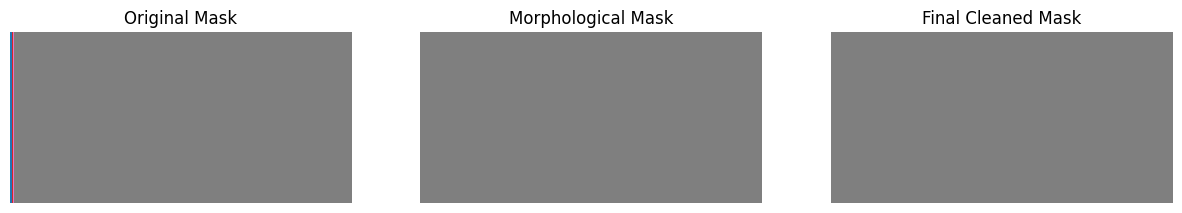

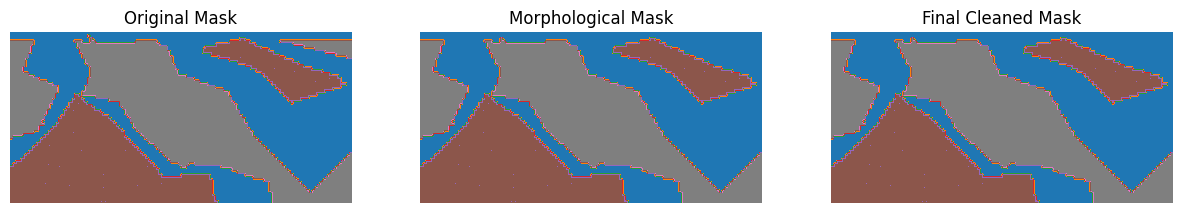

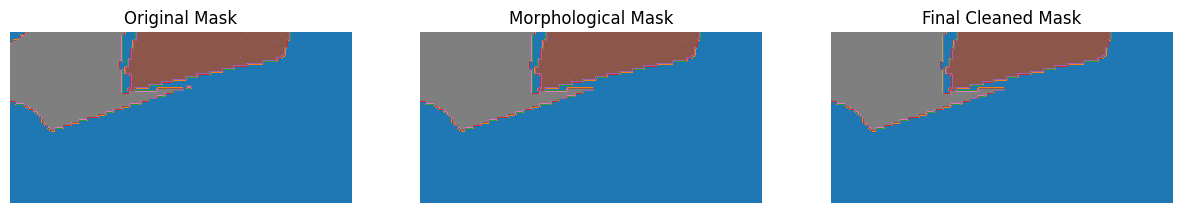

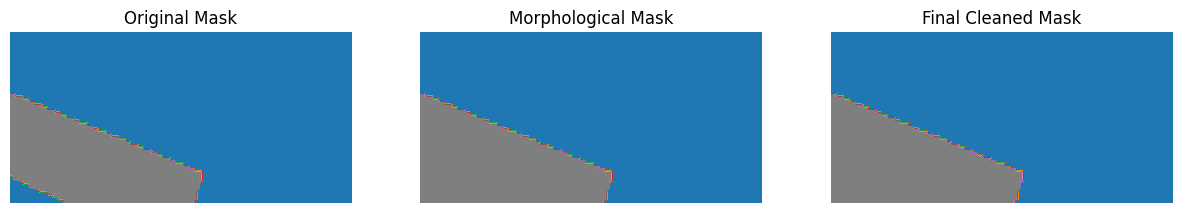

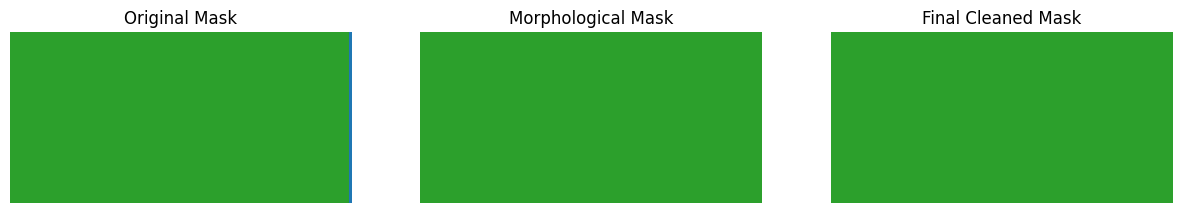

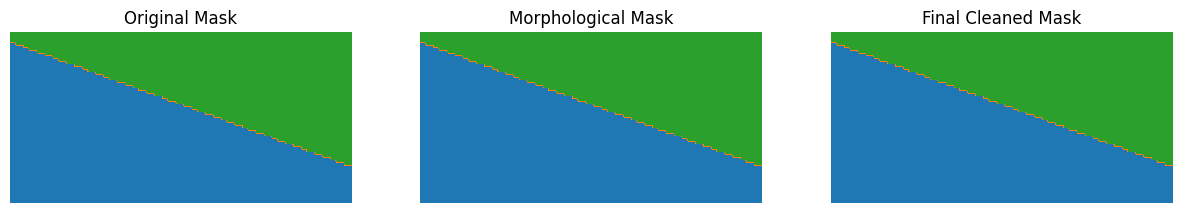

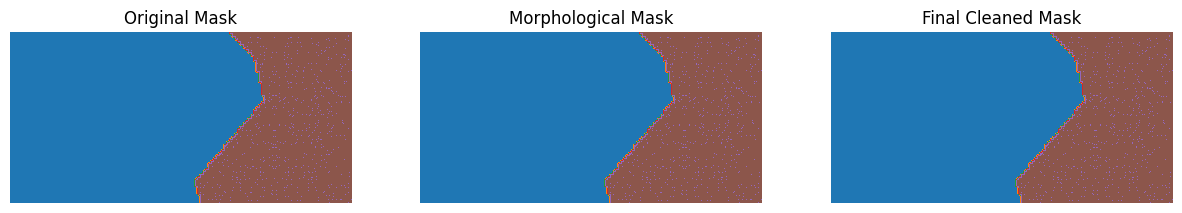

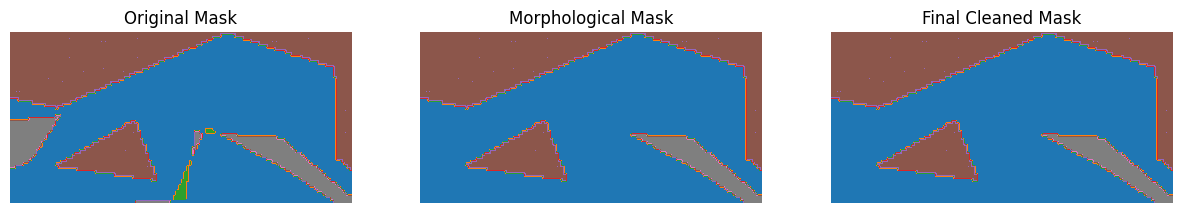

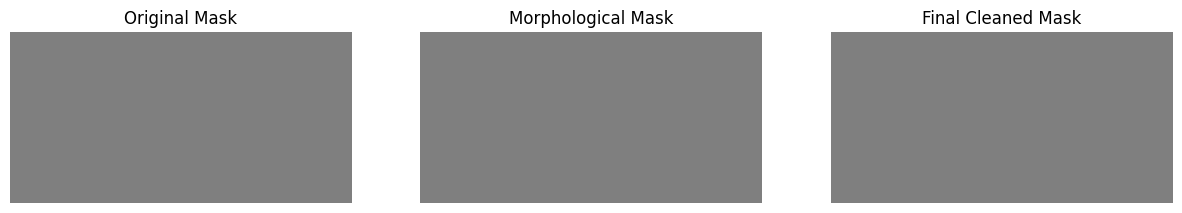

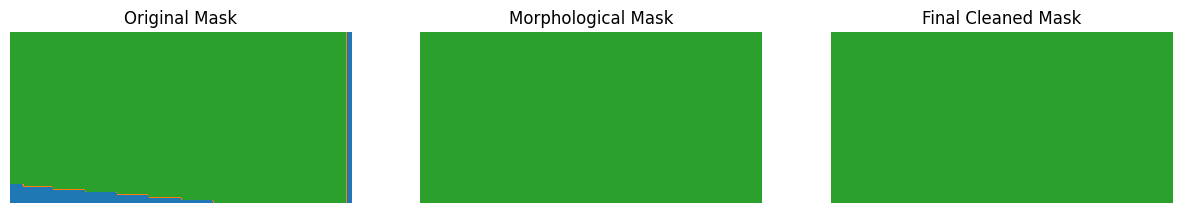

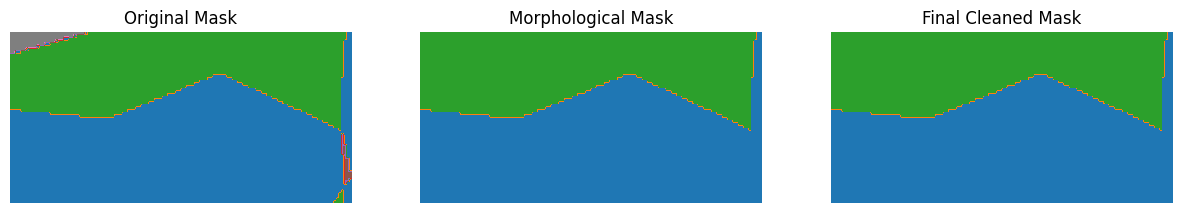

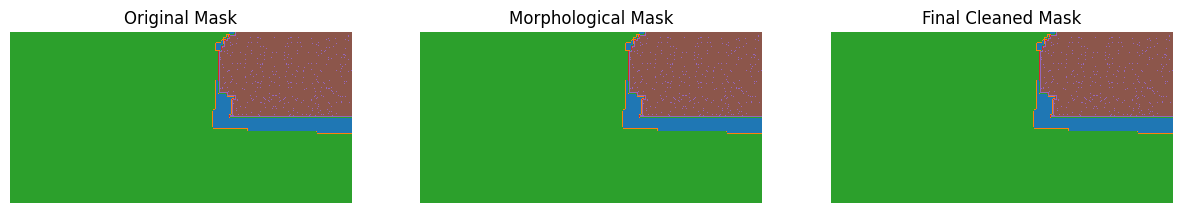

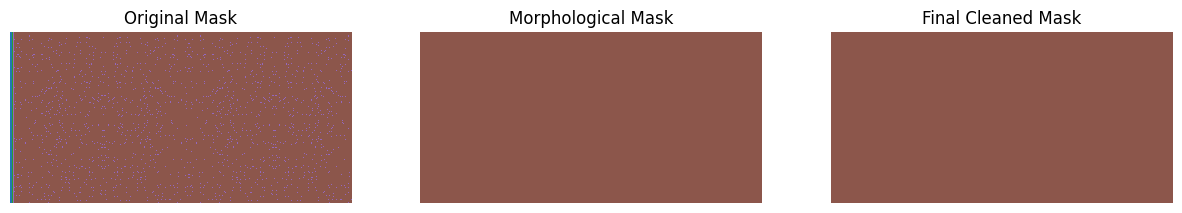

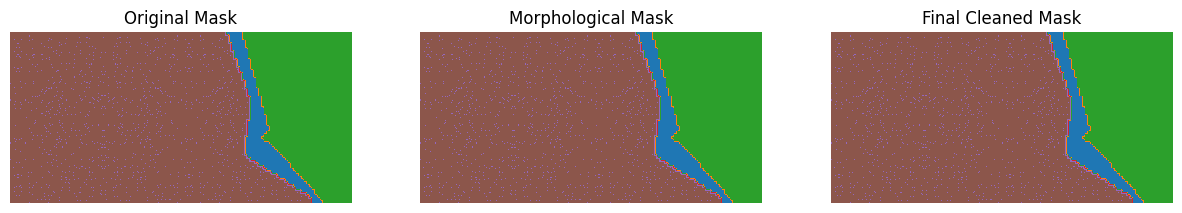

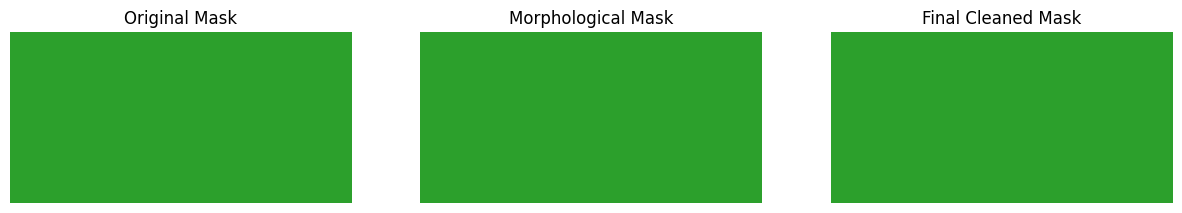

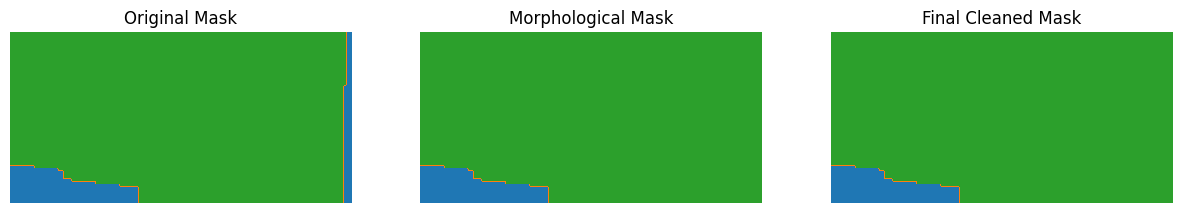

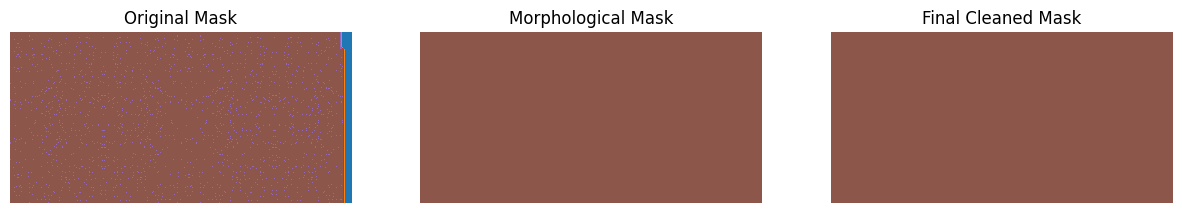

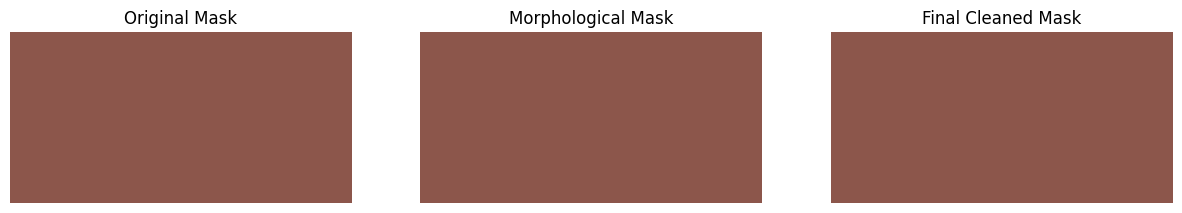

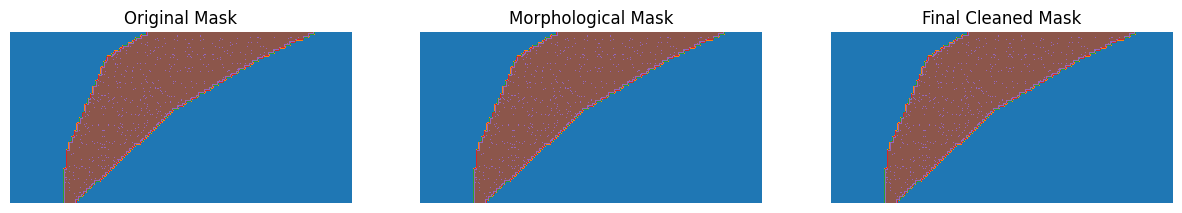

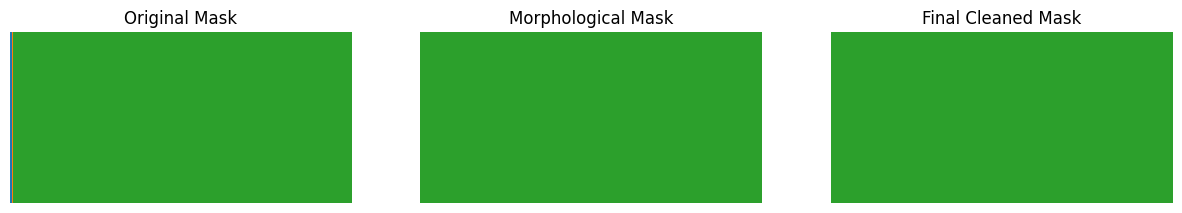

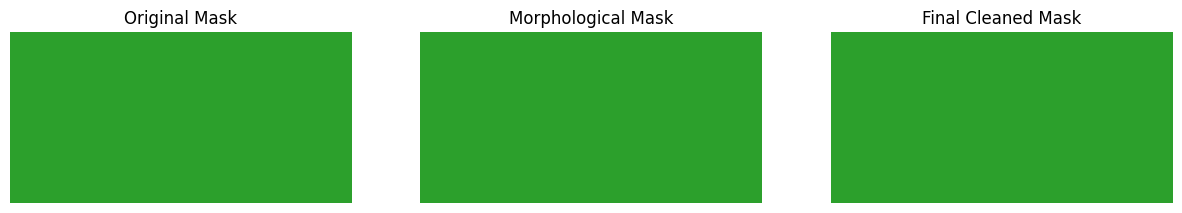

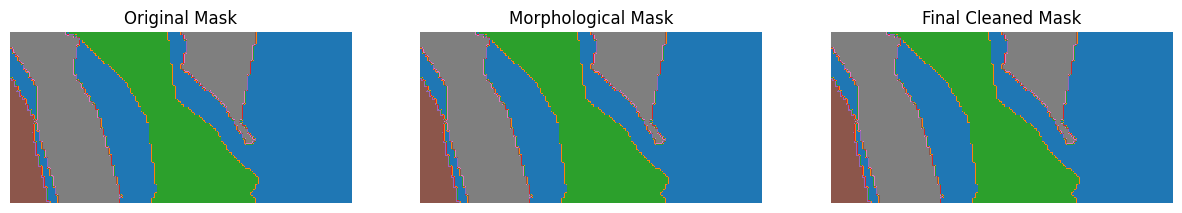

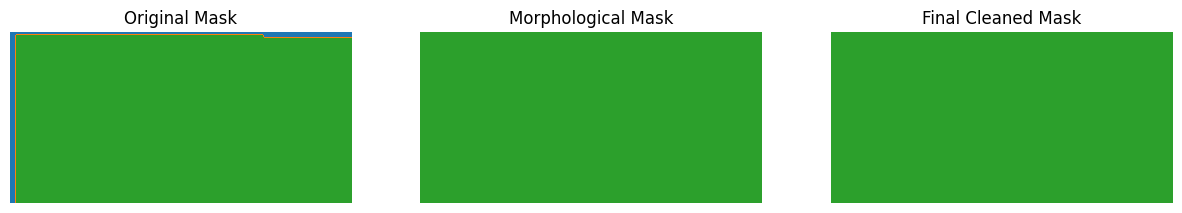

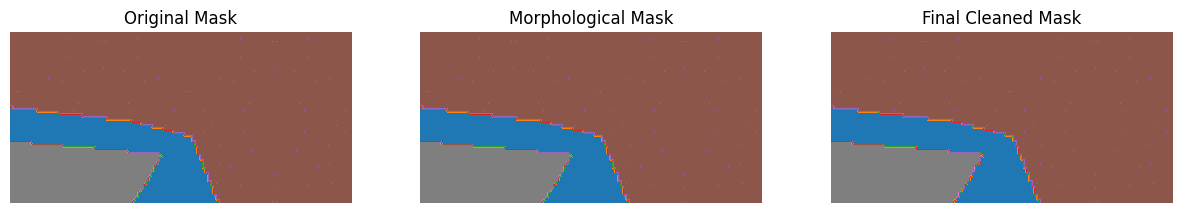

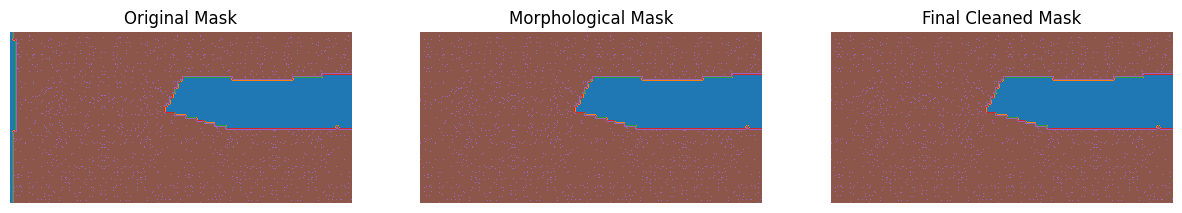

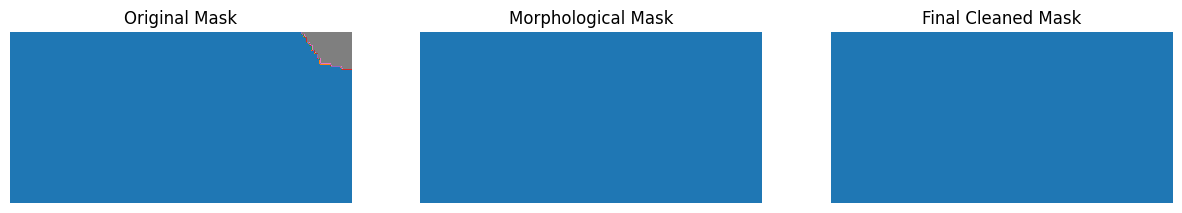

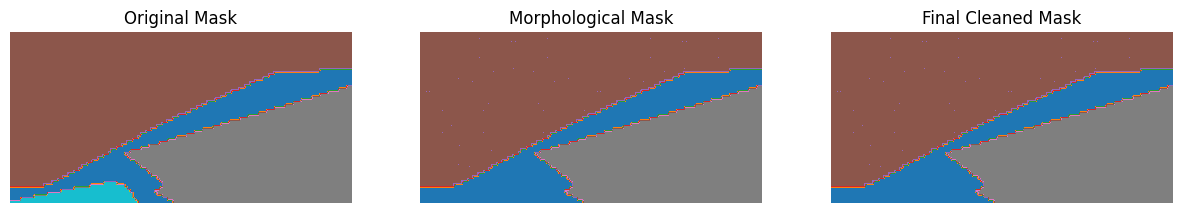

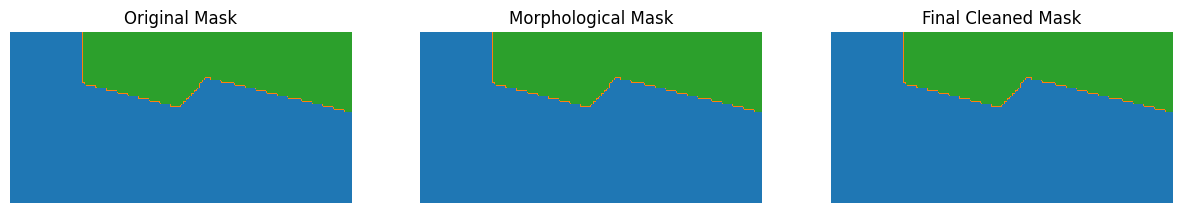

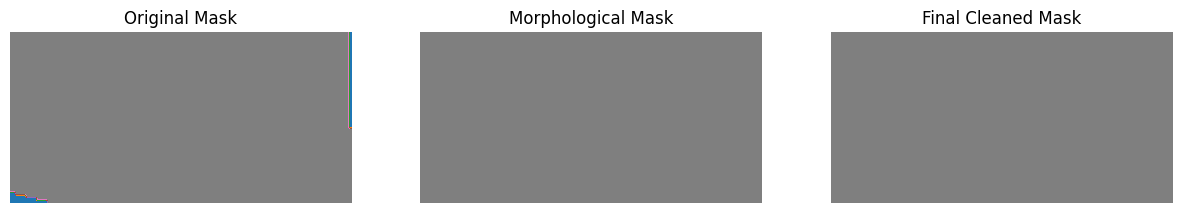

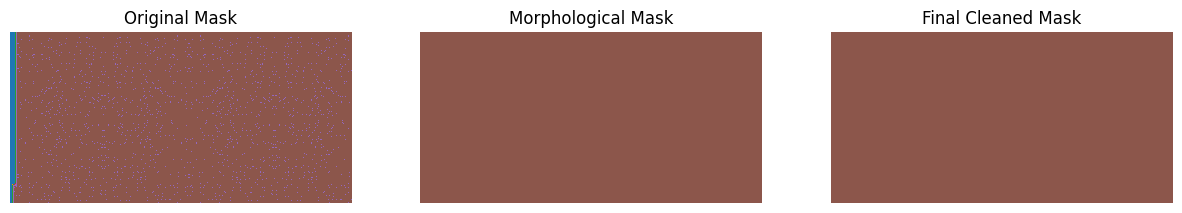

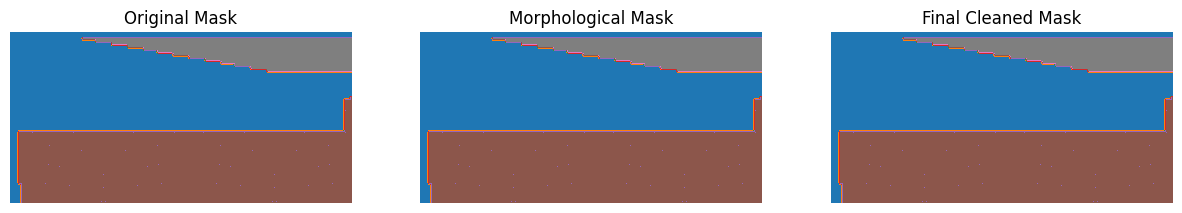

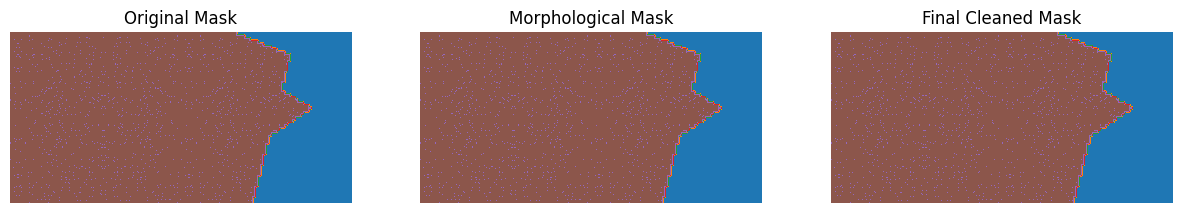

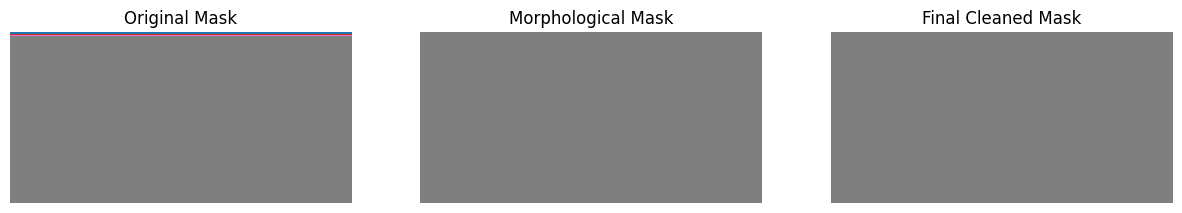

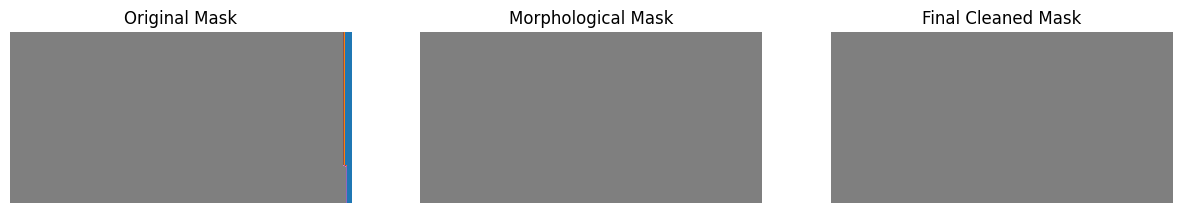

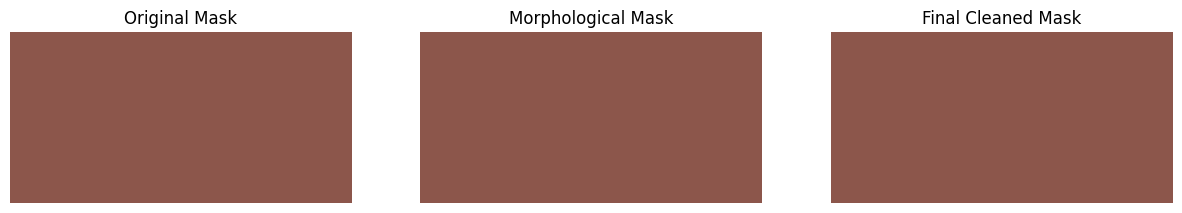

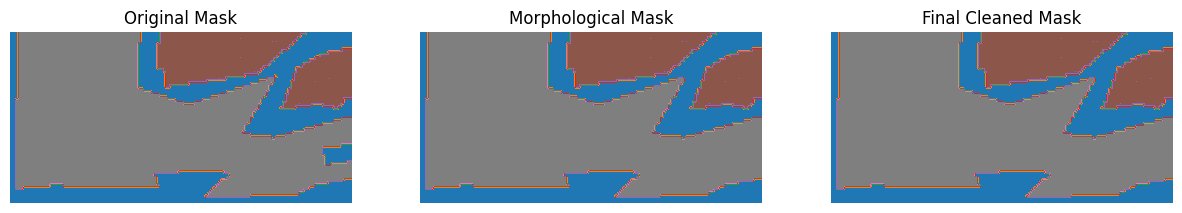

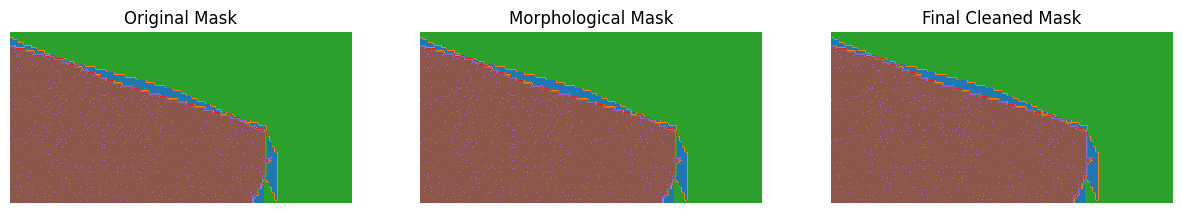

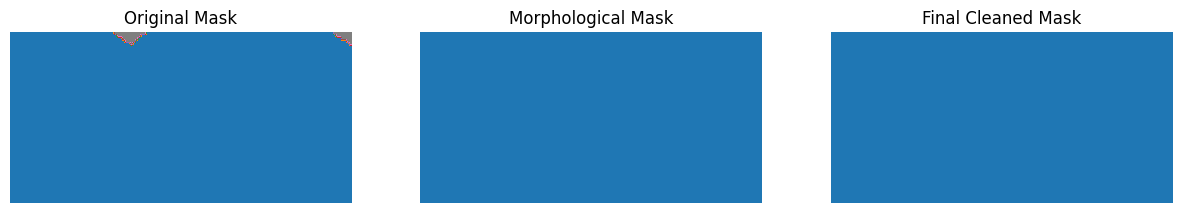

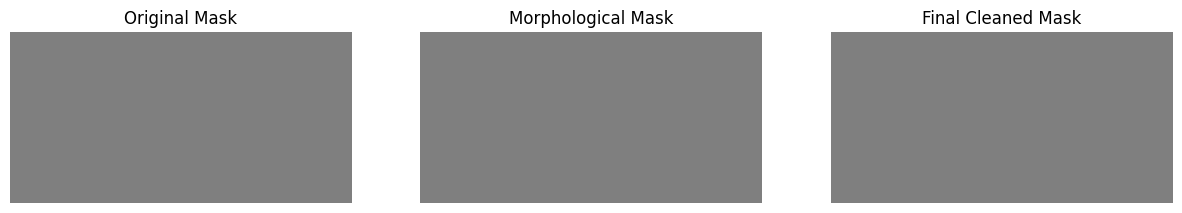

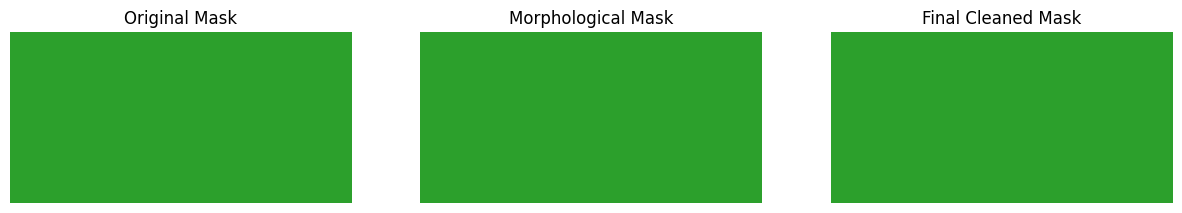

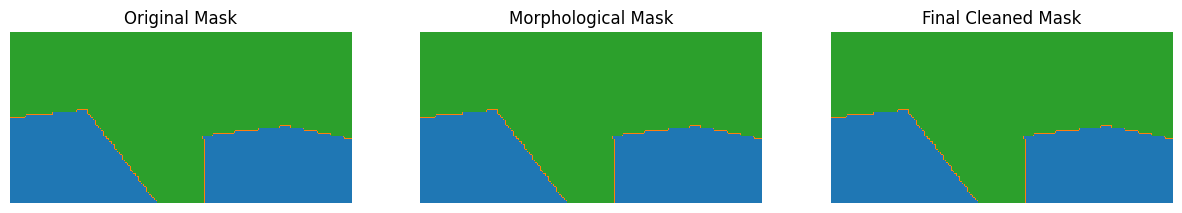

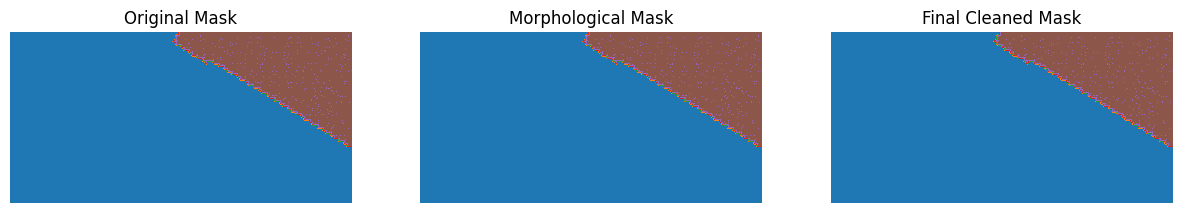

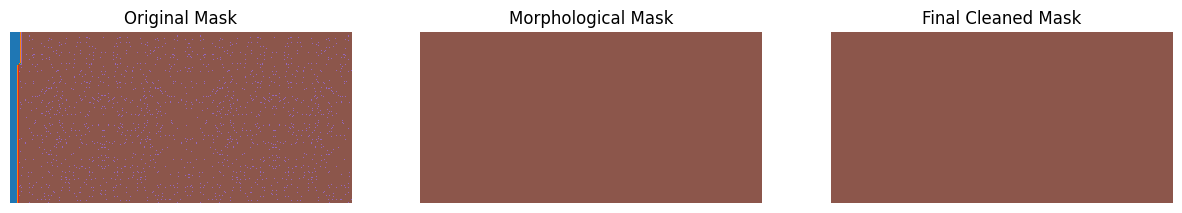

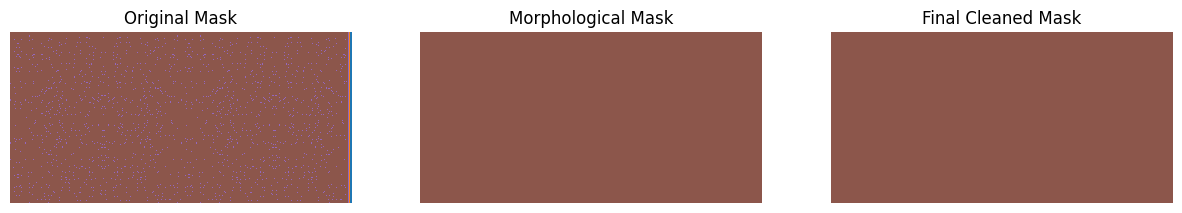

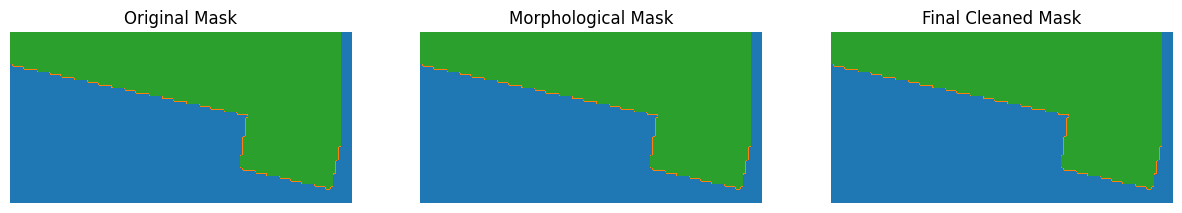

In [ ]:
for i in range(50):  # Visualize the first 5 masks
        visualize_cleaning(y_train[i], y_cleaned[i], y_cleaned[i])


Bedrock: 41193610 pixels
Background: 87832503 pixels
Sand: 38901797 pixels
Soil: 52287604 pixels
Big Rock: 5105446 pixels


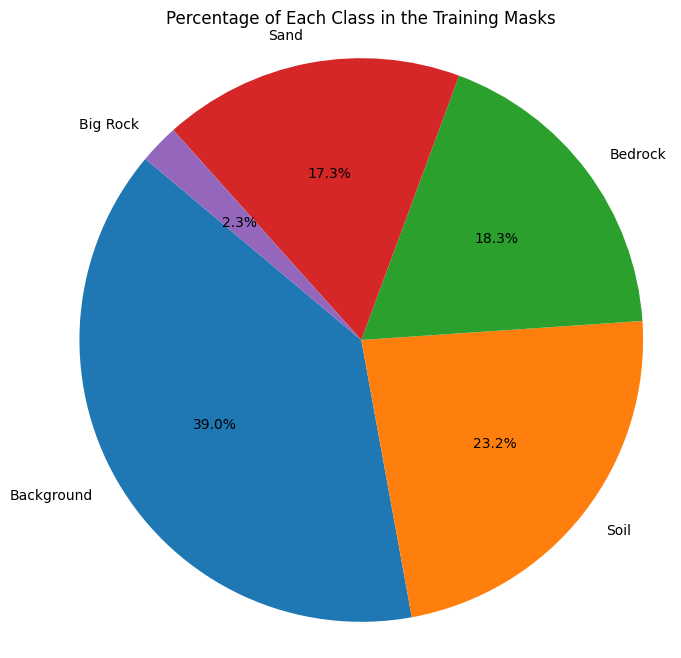

In [ ]:
from collections import Counter
# Define class names (corresponding to terrain labels)
class_names = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']

# Flatten the training masks to calculate class frequencies
flattened_labels = y_cleaned.flatten()

# Count the number of pixels for each class
class_counts = Counter(flattened_labels)

# Print the number of pixels for each class
for class_label, class_count in class_counts.items():
    class_label = int(class_label)  # Ensure the class label is an integer
    print(f'{class_names[class_label]}: {class_count} pixels')

# Calculate total number of pixels
total_pixels = len(flattened_labels)

# Calculate the percentage of each class
percentages = [(class_counts[i] / total_pixels) * 100 for i in range(len(class_names))]

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(percentages, labels=class_names, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title('Percentage of Each Class in the Training Masks')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [ ]:
import numpy as np

# Save the cleaned dataset as an .npz file
def save_cleaned_data(X_train_cleaned, y_train_cleaned, filename="/content/drive/My Drive/cleaned_mars_dataset_with_no_ufo.npz"): # Changed filename to include "My Drive"
    """
    Save cleaned datasets into an .npz file.

    Args:
        X_train_cleaned (numpy array): The cleaned training images.
        y_train_cleaned (numpy array): The cleaned training labels.
        filename (str): Name of the file to save (default: cleaned_dataset.npz).
    """
    np.savez(filename, X_train=X_augmented, y_train=y_cleaned)
    print(f"Cleaned dataset saved to {filename}")

# Example usage
save_cleaned_data(X_augmented, y_cleaned, filename="/content/drive/My Drive/cleaned_mars_dataset_with_no_ufo.npz") # Changed filename to include "My Drive"

Cleaned dataset saved to /content/drive/My Drive/cleaned_mars_dataset_with_no_ufo.npz
